# 1. Get Tweets related to COVID-19 with Twitter API using Tweepy

**Twitter API imposes a Data rate limitation and hence this code is run persistenlty with waiting times (setting parameters wait_on_rate_limit=True, wait_on_rate_limit_notify=True, to handle this). (Consider other alternatives if possible)**

In [1]:
pip install vaderSentiment

     |████████████████████████████████| 133kB 11.0MB/s 


In [2]:
import os
import tweepy as tw
import pandas as pd
import csv
import pandas as pd
import glob
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from sklearn.model_selection import train_test_split
import keras.models
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras import backend as K
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
analyser = SentimentIntensityAnalyzer()

In [ ]:
#Enter your keys here
consumer_key= ''
consumer_secret= ''
access_token= ''
access_token_secret= ''

In [ ]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
search_words = '#COVIDー19 -filter:retweets'
date_since_1 = "2020-10-01"
date_since_2 = "2020-10-20"
date_since_3 = "2020-11-01"
date_since_4 = "2020-11-20"
date_since_5 = "2020-04-01"
date_since_6 = "2020-04-10"
date_since_7 = "2020-04-20"
date_since_8 = "2020-05-01"
date_since_9 = "2020-05-10"
date_since_10 = "2020-05-20"
date_since_11 = "2020-06-01"
date_since_12 = "2020-06-10"
date_since_13 = "2020-06-20"
date_since_14 = "2020-07-01"
date_since_15 = "2020-07-10"
date_since_16 = "2020-07-20"
date_since_17 = "2020-08-01"
date_since_18 = "2020-08-10"
date_since_19 = "2020-08-20"
date_since_20 = "2020-09-01"
date_list = [date_since_9, date_since_10, date_since_11, date_since_12, date_since_13, date_since_14, date_since_15, date_since_16, date_since_17, date_since_18, date_since_19, date_since_20]

In [ ]:
# Function to Collect tweets. Iterator returned.
def tweet_extractor(api, search_words, since_date):
  tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",
              since=since_date).items(3000)
  return tweets

In [ ]:
#function to create the covid19 csv file
def create_covid19_csv_data(csv_name, dict_list):
  field_names= ['Tweet_Id', 'Tweet_Text']

  with open(csv_name, 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()
    writer.writerows(dict_list)

In [ ]:
#Function to persistently create covid-19 data in seperate csv files
def tweet_machine(api,search_words,date_list):
  for date_since in date_list:
    tweets = tweet_extractor(api=api, search_words=search_words, since_date=date_since)
    tweet_dict_list = [{'Tweet_Id':tweet.id, 'Tweet_Text':tweet.text} for tweet in tweets]
    csv_name = 'Tweets_COVID_19_Data_'+ date_since + '.csv'
    create_covid19_csv_data(csv_name=csv_name, dict_list=tweet_dict_list)
    tweet_dict_list.clear()

In [ ]:
tweet_machine(api=api, search_words=search_words, date_list=date_list)

Rate limit reached. Sleeping for: 853
Rate limit reached. Sleeping for: 850
Rate limit reached. Sleeping for: 853
Rate limit reached. Sleeping for: 852
Rate limit reached. Sleeping for: 853
Rate limit reached. Sleeping for: 853
Rate limit reached. Sleeping for: 852
Rate limit reached. Sleeping for: 853
Rate limit reached. Sleeping for: 852
Rate limit reached. Sleeping for: 853
Rate limit reached. Sleeping for: 852
Rate limit reached. Sleeping for: 852
Rate limit reached. Sleeping for: 851


# 2. Data Cleaning

**Concatenate all csv files into one large corpus**

In [4]:
def create_data_corpus(path):
  files = glob.glob(path + "/*.csv")
  df_list = []
  
  for file in files:
    df = pd.read_csv(file, index_col=None, header=0, engine='python')
    df_list.append(df)

  frame = pd.concat(df_list, axis=0, ignore_index=True)
  return frame

**Remove Duplicate entries**

In [ ]:
frame = pd.read_csv('drive/My Drive/Workspace/SentimentAnalysis/TwitterData/Tweets_COVID_19_Data_2020-04-01.csv', index_col=None, header=0)
frame

In [ ]:
frame = frame.drop_duplicates().reset_index(drop=True)
frame

**Remove Twitter Handles and return handles**

In [5]:
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)        
  return input_txt

In [ ]:
frame['Tweet_clean_Text'] = np.vectorize(remove_pattern)(frame['Tweet_Text'], "RT @[\w]*:")
frame.Tweet_clean_Text = np.vectorize(remove_pattern)(frame['Tweet_clean_Text'], "@[\w]*")
frame

**Remove URL Links**

In [ ]:
frame.Tweet_clean_Text = np.vectorize(remove_pattern)(frame['Tweet_clean_Text'], "https?://[A-Za-z0-9./]*")
frame

**Remove special characters, numbers, punctuations (except for #)**

In [ ]:
frame.Tweet_clean_Text = frame.Tweet_clean_Text.str.replace("[^a-zA-Z#]", " ")
frame

**Remove Extra Spaces**

In [ ]:
frame.Tweet_clean_Text = frame.Tweet_clean_Text.replace('\s+', ' ', regex=True)
frame

**Function to carry out data cleaning**

In [6]:
def clean_tweets(frame, column_name, remove_stop_words=True, lower_case=True, remove_special=True):
  frame = frame.drop_duplicates().reset_index(drop=True) #remove duplicate rows
  frame['Tweet_Clean_Text'] = np.vectorize(remove_pattern)(frame[column_name], "RT @[\w]*:") #remove twitter return handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "@[\w]*") #remove twitter handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "https?://[A-Za-z0-9./]*") #remove URLs

  if remove_special:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.str.replace("[^a-zA-Z#]", " ") #remove special characters except for #
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.replace('\s+', ' ', regex=True) #remove extra spaces in between words
  if lower_case:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.apply(lambda x: x.lower())
  if remove_stop_words:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')])) #remove stop words

  return frame

In [8]:
frame = create_data_corpus('drive/My Drive/Workspace/SentimentAnalysis/TwitterData') #Use your own path, I have mounted the data from google drive
covid_19_frame = clean_tweets(frame,'Tweet_Text', remove_stop_words=False, lower_case=False, remove_special=False)
covid_19_frame

,Tweet_Id,Tweet_Text,Tweet_Clean_Text
0,1334926873944584201,"Government could care less about us, they not ...","Government could care less about us, they not ..."
1,1334926692574433280,In #UNGA Special Session on #COVIDー19. Listeni...,In #UNGA Special Session on #COVIDー19. Listeni...
2,1334926689693028354,THINK!\n#COVID19 \n#COVIDー19 \n#FridayThoughts...,THINK! #COVID19 #COVIDー19 #FridayThoughts
3,1334926679442137088,I can see the end of the #cinema. Streaming wi...,I can see the end of the #cinema. Streaming wi...
4,1334926669556019200,"#VT News 📰\n04:12:2020\nFor more promotions📜, ...","#VT News 📰 04:12:2020 For more promotions📜, Le..."
...,...,...,...
4105,1334880135246270464,"As many as 57,405 persons have undergone #Covi...","As many as 57,405 persons have undergone #Covi..."
4106,1334910162470047744,This yrars Christmas album #pixieelittle #porn...,This yrars Christmas album #pixieelittle #porn...
4107,1334910064000372736,📌To reassure the public that #COVIDー19 vaccine...,📌To reassure the public that #COVIDー19 vaccine...
4108,1334909370082189315,This. #COVID19 #COVIDー19 #CovidVaccine #antiv...,This. #COVID19 #COVIDー19 #CovidVaccine #antiva...


# 3. Assign Polarities to the extracted tweets using unsupervised sentiment analysis tools (Data Exploration)

In [10]:
def calculate_sentiment_analyser(Clean_text):    
    return analyser.polarity_scores(Clean_text)

In [11]:
def get_sentiments(frame):
  sentiment_frame = pd.DataFrame(index = range(0,len(frame)),columns= ['pos', 'neu', 'neg', 'compound_score', 'sentiment'])

  for i, row in frame.iterrows():
    sentiment_frame['pos'][i] = analyser.polarity_scores(frame.Tweet_Clean_Text[i])["pos"]
    sentiment_frame['neu'][i] = analyser.polarity_scores(frame.Tweet_Clean_Text[i])["neu"]
    sentiment_frame['neg'][i] = analyser.polarity_scores(frame.Tweet_Clean_Text[i])["neg"]
    sentiment_frame['compound_score'][i] = analyser.polarity_scores(frame.Tweet_Clean_Text[i])["compound"]

    if (sentiment_frame['compound_score'][i] <= -0.05):
      sentiment_frame['sentiment'][i] = 'Negative'    
    elif (sentiment_frame['compound_score'][i] >= 0.05):
      sentiment_frame['sentiment'][i] = 'Positive'
    elif ((sentiment_frame['compound_score'][i] >= -0.05) & (sentiment_frame['compound_score'][i] <= 0.05)):
      sentiment_frame['sentiment'][i] = 'Neutral'

  frame['pos'] = sentiment_frame['pos']
  frame['neu'] = sentiment_frame['neu']
  frame['neg'] = sentiment_frame['neg']
  frame['compound_score'] = sentiment_frame['compound_score']
  frame['sentiment'] = sentiment_frame['sentiment']

  return frame

In [12]:
covid_19_frame = get_sentiments(covid_19_frame)
covid_19_frame

,Tweet_Id,Tweet_Text,Tweet_Clean_Text,pos,neu,neg,compound_score,sentiment
0,1334926873944584201,"Government could care less about us, they not ...","Government could care less about us, they not ...",0.253,0.663,0.084,0.6204,Positive
1,1334926692574433280,In #UNGA Special Session on #COVIDー19. Listeni...,In #UNGA Special Session on #COVIDー19. Listeni...,0.279,0.721,0,0.7351,Positive
2,1334926689693028354,THINK!\n#COVID19 \n#COVIDー19 \n#FridayThoughts...,THINK! #COVID19 #COVIDー19 #FridayThoughts,0,1,0,0,Neutral
3,1334926679442137088,I can see the end of the #cinema. Streaming wi...,I can see the end of the #cinema. Streaming wi...,0.167,0.833,0,0.5598,Positive
4,1334926669556019200,"#VT News 📰\n04:12:2020\nFor more promotions📜, ...","#VT News 📰 04:12:2020 For more promotions📜, Le...",0.114,0.886,0,0.263,Positive
...,...,...,...,...,...,...,...,...
4105,1334880135246270464,"As many as 57,405 persons have undergone #Covi...","As many as 57,405 persons have undergone #Covi...",0,1,0,0,Neutral
4106,1334910162470047744,This yrars Christmas album #pixieelittle #porn...,This yrars Christmas album #pixieelittle #porn...,0,1,0,0,Neutral
4107,1334910064000372736,📌To reassure the public that #COVIDー19 vaccine...,📌To reassure the public that #COVIDー19 vaccine...,0.359,0.641,0,0.8126,Positive
4108,1334909370082189315,This. #COVID19 #COVIDー19 #CovidVaccine #antiv...,This. #COVID19 #COVIDー19 #CovidVaccine #antiva...,0,1,0,0,Neutral


In [13]:
covid_19_frame['sentiment'].value_counts()

Positive    1499
Neutral     1422
Negative    1189
Name: sentiment, dtype: int64

# 4. Preprocess the Dataset(Combined corpus of SemEval2017 + Airlines + subset of Sentiment140) for training the Networks. Finetune the networks using the twitter data obtained previously

In [89]:
mega_frame = create_data_corpus('drive/My Drive/Workspace/SentimentAnalysis/MegaData') #Use your own path, I have mounted the data from google drive
mega_frame = clean_tweets(frame=mega_frame, column_name='Column3', remove_stop_words=False, remove_special=False)
mega_frame

,Column1,Column2,Column3,Tweet_Clean_Text
0,4.343150e+17,negative,@MetroNorth wall to wall people on the platfor...,wall to wall people on the platform at south ...
1,4.376050e+17,neutral,ang sarap mging panganay. Pag ikaw may kylngan...,ang sarap mging panganay. pag ikaw may kylngan...
2,4.374240e+17,negative,RT @katie_rohaley: School on Monday is just go...,school on monday is just gonna be a great time
3,4.368360e+17,negative,Thanks manager for putting me on the schedule ...,thanks manager for putting me on the schedule ...
4,4.356710e+17,negative,Who needs sleep? It's not like I have a test t...,who needs sleep? it's not like i have a test t...
...,...,...,...,...
114213,2.192225e+09,positive,Hahaha! @futureguru100 that was just a work p...,hahaha! that was just a work project... he cou...
114214,2.191751e+09,positive,And the award for 'Longest Ever Interview' goe...,and the award for 'longest ever interview' goe...
114215,1.468895e+09,negative,Thinks!!!!!! i should have rented wheelman,thinks!!!!!! i should have rented wheelman
114216,1.469237e+09,negative,@MaryBethune I hate school right now! You are ...,i hate school right now! you are lucky you do...


In [112]:
mega_frame['Column2'].value_counts()

positive    47028
negative    41842
neutral     25348
Name: Column2, dtype: int64

# Build the Inputs and LSTM network

**Change labels to integer as its easier to feed as an input / one hot encode them**

In [90]:
#from sklearn.preprocessing import LabelBinarizer
#lb = LabelBinarizer()

#Solution1
mega_frame["Sentiment_Value"] = mega_frame["Column2"].map({"neutral": 0, "positive": 1, "negative": 2})
lbl = to_categorical(mega_frame["Sentiment_Value"], 3)

#Solution2
#one_hot = pd.get_dummies(mega_frame['Column2'])
#mega_frame = mega_frame.join(one_hot)

#Solution3
#mega_frame = mega_frame.join(pd.DataFrame(lb.fit_transform(mega_frame["Column2"]),
#                          columns=lb.classes_, 
#                          index=mega_frame.index))
mega_frame

,Column1,Column2,Column3,Tweet_Clean_Text,Sentiment_Value
0,4.343150e+17,negative,@MetroNorth wall to wall people on the platfor...,wall to wall people on the platform at south ...,2
1,4.376050e+17,neutral,ang sarap mging panganay. Pag ikaw may kylngan...,ang sarap mging panganay. pag ikaw may kylngan...,0
2,4.374240e+17,negative,RT @katie_rohaley: School on Monday is just go...,school on monday is just gonna be a great time,2
3,4.368360e+17,negative,Thanks manager for putting me on the schedule ...,thanks manager for putting me on the schedule ...,2
4,4.356710e+17,negative,Who needs sleep? It's not like I have a test t...,who needs sleep? it's not like i have a test t...,2
...,...,...,...,...,...
114213,2.192225e+09,positive,Hahaha! @futureguru100 that was just a work p...,hahaha! that was just a work project... he cou...,1
114214,2.191751e+09,positive,And the award for 'Longest Ever Interview' goe...,and the award for 'longest ever interview' goe...,1
114215,1.468895e+09,negative,Thinks!!!!!! i should have rented wheelman,thinks!!!!!! i should have rented wheelman,2
114216,1.469237e+09,negative,@MaryBethune I hate school right now! You are ...,i hate school right now! you are lucky you do...,2


**Vectorize and convert text into sequences**

In [94]:
# Approach 1 - Keras Tokenizer
maxlen = mega_frame['Tweet_Clean_Text'].apply(lambda x: len(x.split())).max()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(mega_frame['Tweet_Clean_Text'].values)
num_features = len(tokenizer.word_index) + 1
X = tokenizer.texts_to_sequences(mega_frame['Tweet_Clean_Text'].values)
X = pad_sequences(X, maxlen=maxlen, padding='post')

In [95]:
# Approach 2 - GloVe embeddings
def get_w2v(path):
  file = open(path)
  w2v = {}
  for embedding_line in file:
    embedding_word = embedding_line.split()[0]
    embedding_value = np.asarray([float(value) for value in embedding_line.split()[1:]])
    w2v[embedding_word] = embedding_value
  return w2v

In [96]:
glove_file_path = "drive/My Drive/Workspace/SentimentAnalysis/GloVe/glove.twitter.27B.200d.txt"
w2v = get_w2v(glove_file_path)

In [97]:
emb_mat = np.zeros((num_features, 200))
for word, i in tokenizer.word_index.items():
  vector = w2v.get(word)
  if vector is not None:
    emb_mat[i] = vector
  else:
    emb_mat[i] = np.random.randn(200)

**Create Training, Validation, and Test Data splits**

In [98]:
#Y = mega_frame['Sentiment_Value']
Y = lbl

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.10, random_state = 1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=1)

In [99]:
lbl

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

**Define the model**

In [101]:
output_dims = 200
lstm_out = 200

model = keras.Sequential([
    layers.Embedding(input_dim=num_features, output_dim=output_dims, input_length=X.shape[1], weights=[emb_mat], trainable=True),
    layers.SpatialDropout1D(0.4),
    layers.Bidirectional(layers.LSTM(units=lstm_out, dropout=0.4, recurrent_dropout=0.4, return_sequences=False)),
    layers.Dense(units=3, activation='softmax')
    ])

In [102]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 200)           14691200  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 39, 200)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 400)               641600    
_________________________________________________________________
dense (Dense)                (None, 3)                 1203      
Total params: 15,334,003
Trainable params: 15,334,003
Non-trainable params: 0
_________________________________________________________________


In [103]:
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    recall_score.__name__ = 'recall'
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    precision_score.__name__ = 'precision'
    return precision

def f1_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_metrics.__name__ = 'f1'
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

metrics = [
           keras.metrics.CategoricalAccuracy(),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           f1_metrics,
           #keras.metrics.TruePositives(name='tp'),
           #keras.metrics.FalsePositives(name='fp'),
           #keras.metrics.TrueNegatives(name='tn'),
           #keras.metrics.FalseNegatives(name='fn'),
]

model.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

**Useful plot function**

In [104]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 15, 10

In [105]:
def plot_metrics(history):
  metrics = ['loss', 'categorical_accuracy', 'precision', 'recall', 'f1_metrics']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

**Load Model Function**

In [106]:
def load_model(path):
  return keras.models.load_model(path)

**Save only the best weights and model(determined after every epoch)**

In [108]:
checkpoint_filepath = 'drive/My Drive/Workspace/SentimentAnalysis/Model'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_f1_metrics',
    mode='max',
    save_best_only=True,
    save_freq='epoch')

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=3, min_lr=0.00001)

**Train Model**

In [109]:
history = model.fit(x_train, y_train, epochs = 25, batch_size=3000, validation_data=(x_val,y_val), callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/25
31/31 [==============================] - 31s 727ms/step - loss: 1.0055 - categorical_accuracy: 0.4820 - precision: 0.6014 - recall: 0.1754 - f1_metrics: 0.2313 - val_loss: 0.7789 - val_categorical_accuracy: 0.6420 - val_precision: 0.6796 - val_recall: 0.5756 - val_f1_metrics: 0.6241
INFO:tensorflow:Assets written to: drive/My Drive/Workspace/SentimentAnalysis/Model/assets
Epoch 2/25
31/31 [==============================] - 22s 720ms/step - loss: 0.8235 - categorical_accuracy: 0.6175 - precision: 0.6660 - recall: 0.5155 - f1_metrics: 0.5811 - val_loss: 0.7362 - val_categorical_accuracy: 0.6629 - val_precision: 0.6943 - val_recall: 0.6103 - val_f1_metrics: 0.6493
INFO:tensorflow:Assets written to: drive/My Drive/Workspace/SentimentAnalysis/Model/assets
Epoch 3/25
31/31 [==============================] - 22s 720ms/step - loss: 0.7751 - categorical_accuracy: 0.6468 - precision: 0.6894 - recall: 0.5648 - f1_metrics: 0.6209 - val_loss: 0.7096 - val_categorical_accuracy: 0.6781 - v

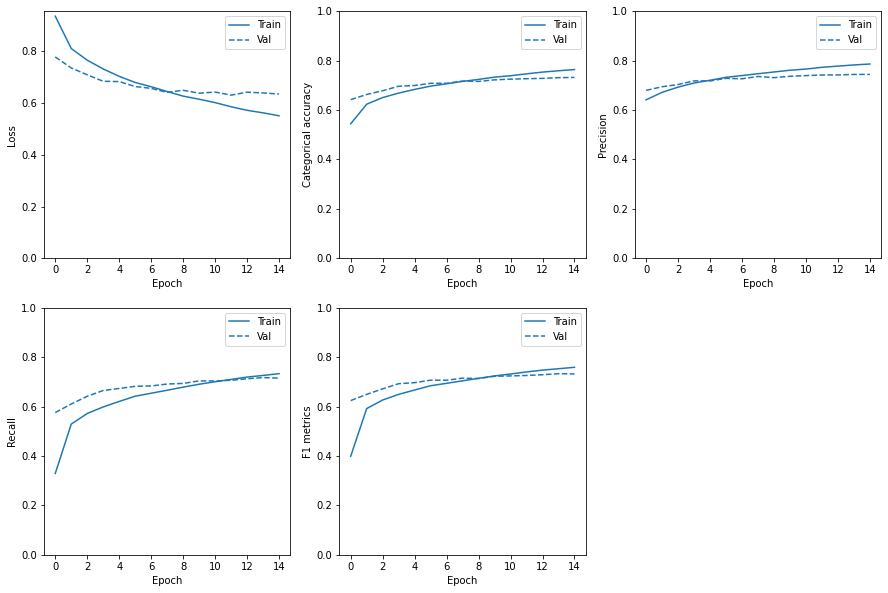

In [110]:
plot_metrics(history)